In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import datetime
import time

In [2]:
meta = pd.read_csv('../../../d11_traffic_data/meta/d11/d11_text_meta_2015_01_01.txt', sep='\t')
meta = meta[['ID', 'Fwy','District', 'Dir','Latitude', 'Longitude']]

In [3]:
raw_5_min_data = pd.read_csv('../../../five_min_frame.csv')

In [4]:
def reduce_data_by_dict(_df, keyval_dict):
    for key, val in keyval_dict.iteritems():
        #print key, val
        _df = _df[_df[key] == val]
    return _df

In [5]:
keyval_dict = {"District": 11, "Freeway #": 5,  "Lane Type": 'ML', "Direction": 'S'} 
freeway_redux = reduce_data_by_dict(raw_5_min_data, keyval_dict)

meta_dict= {"District": 11, "Fwy": 5,  "Dir": 'S'}
meta_redux = reduce_data_by_dict(meta, meta_dict)

Direction S
Lane Type ML
Freeway # 5
District 11


In [7]:
freeway = freeway_redux.merge(meta_redux, 
                              left_on=['Station', 'District','Freeway #', 'Direction'], 
                              right_on=['ID', 'District', 'Fwy', 'Dir'])
freeway = freeway[freeway['% Observed'] > 95 ]
freeway['time'] = pd.to_datetime(freeway['Timestamp'], format="%m/%d/%Y %H:%M:%S")
freeway['timeOfDay'] = freeway['time'].apply(lambda x: x.strftime("%H:%M")) 
freeway_metrics = freeway[['Station', 'Total Flow', 'Avg Occupancy', 'Avg Speed', 'timeOfDay', 'Latitude'] ]
freeway_metrics['Avg Density'] = freeway_metrics['Total Flow']/freeway_metrics['Avg Speed']
fwy_grouping = freeway_metrics[['Station', 'Total Flow', 'Avg Occupancy', 'Avg Speed', 'Avg Density', 'timeOfDay', 'Latitude'] ].groupby(['timeOfDay', 'Station']).agg(['mean','std'])

In [22]:
i5S_metrics = fwy_grouping.reset_index()
i5S_metrics.columns = ['time', 'Station', 'MeanTotalFlow','StdTotalFlow', 
                                                    'MeanAvgOccupancy', 'StdAvgOccupancy',
                                                    'MeanAvgSpeed', 'StdAvgSpeed', 
                                                    'MeanAvgDensity', 'StdAvgDensity',
                                                    'Latitude', 'Nothing']

In [26]:
i5S_metrics['MeanPlusStdTotalFlow'] = i5S_metrics['MeanTotalFlow'] + i5S_metrics['StdTotalFlow']
i5S_metrics['MeanMinusStdTotalFlow'] = i5S_metrics['MeanTotalFlow'] - i5S_metrics['StdTotalFlow']

i5S_metrics['MeanPlusStdOccupancy'] = i5S_metrics['MeanAvgOccupancy'] + i5S_metrics['StdAvgOccupancy']
i5S_metrics['MeanMinusStdOccupancy'] = i5S_metrics['MeanAvgOccupancy'] - i5S_metrics['StdAvgOccupancy']

i5S_metrics['MeanPlusStdAvgSpeed'] = i5S_metrics['MeanAvgSpeed'] + i5S_metrics['StdAvgSpeed']
i5S_metrics['MeanMinusStdAvgSpeed'] = i5S_metrics['MeanAvgSpeed'] - i5S_metrics['StdAvgSpeed']

i5S_metrics['MeanPlusStdAvgDensity'] = i5S_metrics['MeanAvgDensity'] + i5S_metrics['StdAvgDensity']
i5S_metrics['MeanMinusStdAvgDensity'] = i5S_metrics['MeanAvgDensity'] - i5S_metrics['StdAvgDensity']

In [108]:
i5S_metrics = i5S_metrics[['time', 'Station', 'Latitude', 'MeanTotalFlow','MeanPlusStdTotalFlow', 'MeanMinusStdTotalFlow',
                                                    'MeanAvgOccupancy', 'MeanPlusStdOccupancy', 'MeanMinusStdOccupancy',
                                                    'MeanAvgSpeed', 'MeanPlusStdAvgSpeed', 'MeanMinusStdAvgSpeed',
                                                    'MeanAvgDensity', 'MeanPlusStdAvgDensity', 'MeanMinusStdAvgDensity',
                                                    ]].sort_values(['Latitude', 'time'])

In [138]:
i5S_metrics['Latitude']  = i5S_metrics['Latitude'].apply(lambda x: round(x,5))

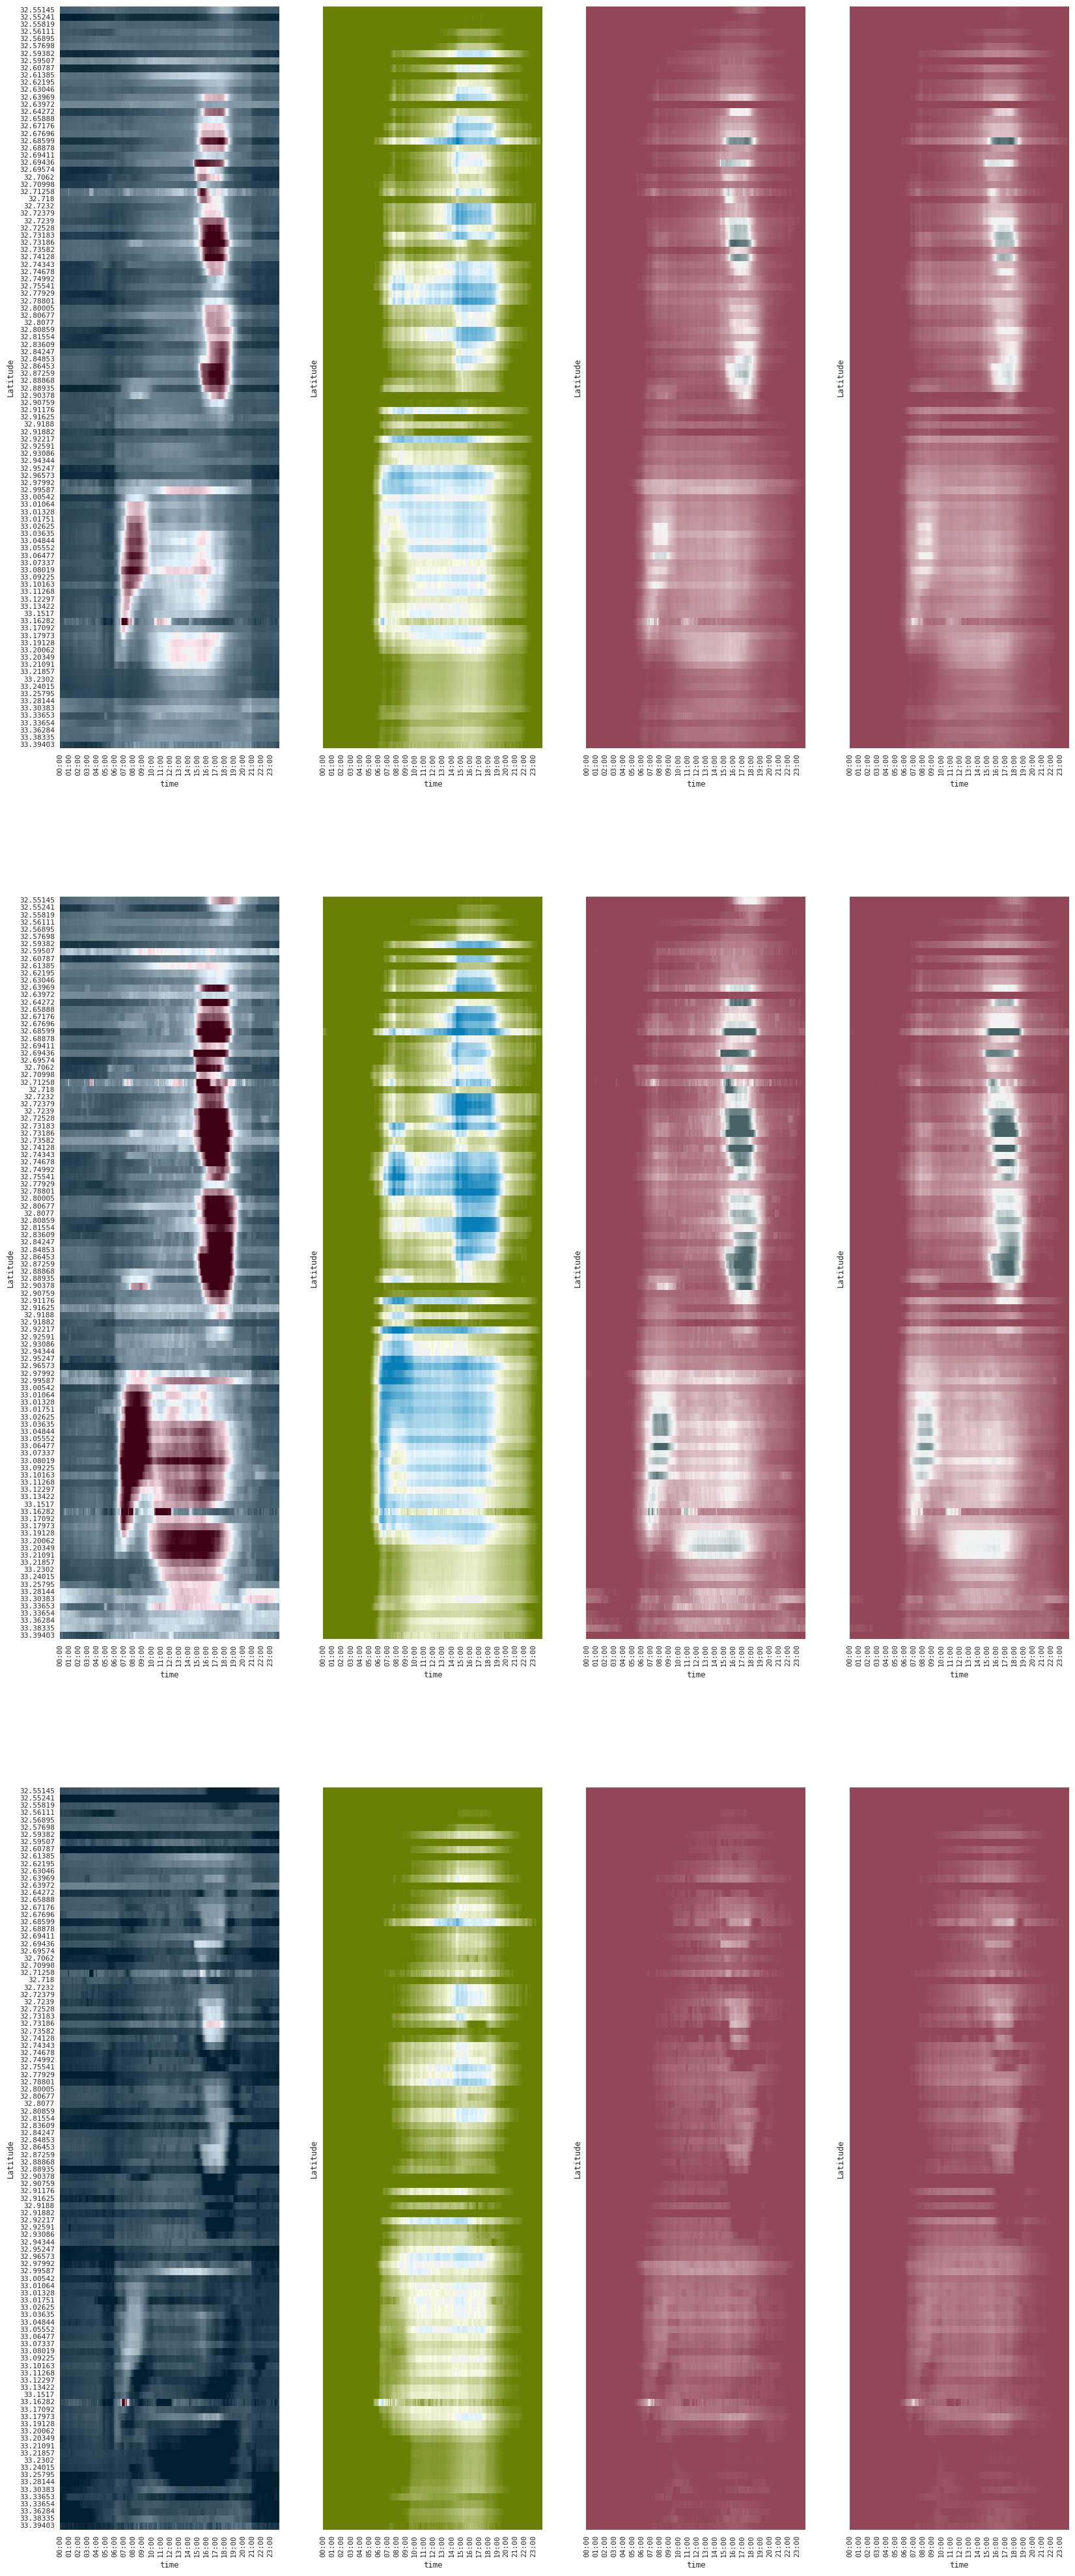

In [141]:
# Set up the matplotlib figure
f, axes = plt.subplots(3, 4, figsize=(20, 50), sharey=True)
sns.despine(left=True)

sns.set(context="paper", font="monospace")
cmap = sns.diverging_palette(h_neg=0, h_pos=240, s=99, l=10,as_cmap=True, center='light')
sns.heatmap(i5S_metrics[['Latitude', 'time', 'MeanAvgSpeed']].pivot("Latitude", "time","MeanAvgSpeed" ), vmin=i5S_metrics['MeanPlusStdAvgSpeed'].min(), vmax=i5S_metrics['MeanAvgSpeed'].max(), ax=axes[0, 0], cmap=cmap, cbar=False, xticklabels=12)
sns.heatmap(i5S_metrics[['Latitude', 'time', 'MeanPlusStdAvgSpeed']].pivot("Latitude", "time","MeanPlusStdAvgSpeed" ),vmin=i5S_metrics['MeanPlusStdAvgSpeed'].min(), vmax=i5S_metrics['MeanAvgSpeed'].max(), ax=axes[2, 0], cmap=cmap, cbar=False, xticklabels=12)
sns.heatmap(i5S_metrics[['Latitude', 'time', 'MeanMinusStdAvgSpeed']].pivot("Latitude", "time","MeanMinusStdAvgSpeed" ), vmin=i5S_metrics['MeanPlusStdAvgSpeed'].min(), vmax=i5S_metrics['MeanAvgSpeed'].max(), ax=axes[1, 0], cmap=cmap, cbar=False, xticklabels=12)

cmap = sns.diverging_palette(h_neg=100, h_pos=240, s=99, l=50,as_cmap=True, center='light')
sns.heatmap(i5S_metrics[['Latitude', 'time', 'MeanTotalFlow']].pivot("Latitude", "time","MeanTotalFlow" ), vmin=i5S_metrics['MeanMinusStdTotalFlow'].mean(), vmax=i5S_metrics['MeanTotalFlow'].max(), ax=axes[0, 1], cmap=cmap, cbar=False, xticklabels=12)
sns.heatmap(i5S_metrics[['Latitude', 'time', 'MeanPlusStdTotalFlow']].pivot("Latitude", "time","MeanPlusStdTotalFlow" ), vmin=i5S_metrics['MeanMinusStdTotalFlow'].mean(), vmax=i5S_metrics['MeanTotalFlow'].max(), ax=axes[1, 1], cmap=cmap, cbar=False, xticklabels=12)
sns.heatmap(i5S_metrics[['Latitude', 'time', 'MeanMinusStdTotalFlow']].pivot("Latitude", "time","MeanMinusStdTotalFlow" ), vmin=i5S_metrics['MeanMinusStdTotalFlow'].mean(), vmax=i5S_metrics['MeanTotalFlow'].max(), ax=axes[2, 1], cmap=cmap, cbar=False, xticklabels=12)


cmap = sns.diverging_palette(h_neg=0, h_pos=200, s=45, l=40, as_cmap=True, center='light')
sns.heatmap(i5S_metrics[['Latitude', 'time', 'MeanAvgOccupancy']].pivot("Latitude", "time","MeanAvgOccupancy" ), vmin=i5S_metrics['MeanMinusStdOccupancy'].mean(), vmax=i5S_metrics['MeanAvgOccupancy'].max(), ax=axes[0, 2], cmap=cmap, cbar=False, xticklabels=12)
sns.heatmap(i5S_metrics[['Latitude', 'time', 'MeanPlusStdOccupancy']].pivot("Latitude", "time","MeanPlusStdOccupancy" ), vmin=i5S_metrics['MeanMinusStdOccupancy'].mean(), vmax=i5S_metrics['MeanAvgOccupancy'].max(), ax=axes[1, 2], cmap=cmap, cbar=False, xticklabels=12)
sns.heatmap(i5S_metrics[['Latitude', 'time', 'MeanMinusStdOccupancy']].pivot("Latitude", "time","MeanMinusStdOccupancy" ), vmin=i5S_metrics['MeanMinusStdOccupancy'].mean(), vmax=i5S_metrics['MeanAvgOccupancy'].max(), ax=axes[2, 2], cmap=cmap, cbar=False, xticklabels=12)


cmap = sns.diverging_palette(h_neg=0, h_pos=200, s=45, l=40, as_cmap=True, center='light')
sns.heatmap(i5S_metrics[['Latitude', 'time', 'MeanAvgDensity']].pivot("Latitude", "time","MeanAvgDensity" ), vmin=i5S_metrics['MeanMinusStdAvgDensity'].mean(), vmax=i5S_metrics['MeanAvgDensity'].max(), ax=axes[0, 3], cmap=cmap, cbar=False,xticklabels=12)
sns.heatmap(i5S_metrics[['Latitude', 'time', 'MeanPlusStdAvgDensity']].pivot("Latitude", "time","MeanPlusStdAvgDensity" ), vmin=i5S_metrics['MeanMinusStdAvgDensity'].mean(), vmax=i5S_metrics['MeanAvgDensity'].max(), ax=axes[1, 3], cmap=cmap, cbar=False, xticklabels=12)
sns.heatmap(i5S_metrics[['Latitude', 'time', 'MeanMinusStdAvgDensity']].pivot("Latitude", "time","MeanMinusStdAvgDensity" ), vmin=i5S_metrics['MeanMinusStdAvgDensity'].mean(), vmax=i5S_metrics['MeanAvgDensity'].max(), ax=axes[2, 3], cmap=cmap, cbar=False, xticklabels=12)